In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    
    return S

In [3]:
def payoff_fun(S, K):
    return np.maximum(K - S, 0)

In [4]:
def create_shallow_NN(input_dim, hidden_units):
    
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    
    return model


In [5]:
def black_scholes(S, K, r, sigma, T, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [6]:
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0

In [7]:
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)

### Start the model

In [8]:
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 6
M = 10000

In [9]:
## Generate the Stock Price Paths
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, M)
payoff_T = payoff_fun(stock_paths[:, -1], K)

In [10]:
normalizer = np.mean(stock_paths[:, -1])
normalized_stock_paths = stock_paths[:, -1]/normalizer
X = normalized_stock_paths.reshape(-1, 1)
y = payoff_T.reshape(-1, 1)
X.shape, y.shape

((10000, 1), (10000, 1))

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
## Create the Neural Network
no_hidden_units = 4
input_dim = 1
model = create_shallow_NN(input_dim, no_hidden_units)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True,
                                   start_from_epoch=100)
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Provide validation data for monitoring
    epochs=5000,                       # Set a high max epoch count; early stopping will limit training
    batch_size=int(0.1 * X_train.shape[0]),  # Set batch size as a fraction of training data size
    callbacks= [early_stopping],  # Use early stopping
    verbose=1
)

Epoch 1/5000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.7923 - val_loss: 27.1709
Epoch 2/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.7761 - val_loss: 27.1048
Epoch 3/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.0656 - val_loss: 27.0310
Epoch 4/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.5621 - val_loss: 26.9499
Epoch 5/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.5859 - val_loss: 26.8576
Epoch 6/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.3243 - val_loss: 26.7529
Epoch 7/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.4144 - val_loss: 26.6349
Epoch 8/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.9970 - val_loss: 26.5033
Epoch 9/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.1333 - val_loss: 26.3587
Epoch 10/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.0941 - val_loss: 26.2018
Epoch 11/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.4285 - val_loss: 26.0319
Epoch 12/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


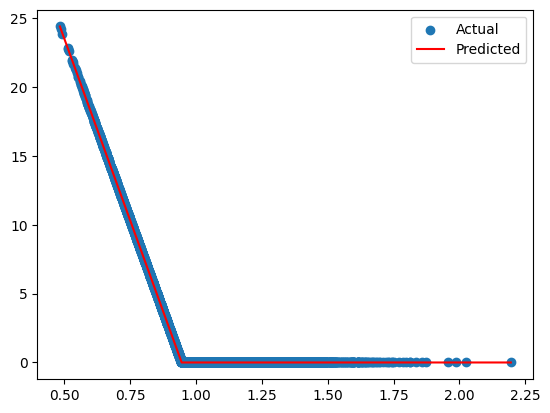

In [13]:
# Test the model
y_hat_val = model.predict(X_train)
plt.scatter(X_train, y_train, label='Actual')
# Sort X_train and y_hat for a smoother line plot
sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
X_train_sorted = X_train[sorted_indices]
y_hat_sorted = y_hat_val[sorted_indices]
plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
plt.legend()

In [14]:
w1 = model.layers[0].get_weights()[0].reshape(-1)
b1 = model.layers[0].get_weights()[1].reshape(-1)
w2 = model.layers[1].get_weights()[0].reshape(-1)
b2 = model.layers[1].get_weights()[1].reshape(-1)
dt = T/N
r = mu
continuation_val = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, -2], r , sigma, dt, M, normalizer)

In [15]:
payoff_at2 = payoff_fun(stock_paths[:, -2], K)
Vt_m_1 = np.maximum(payoff_at2, continuation_val)

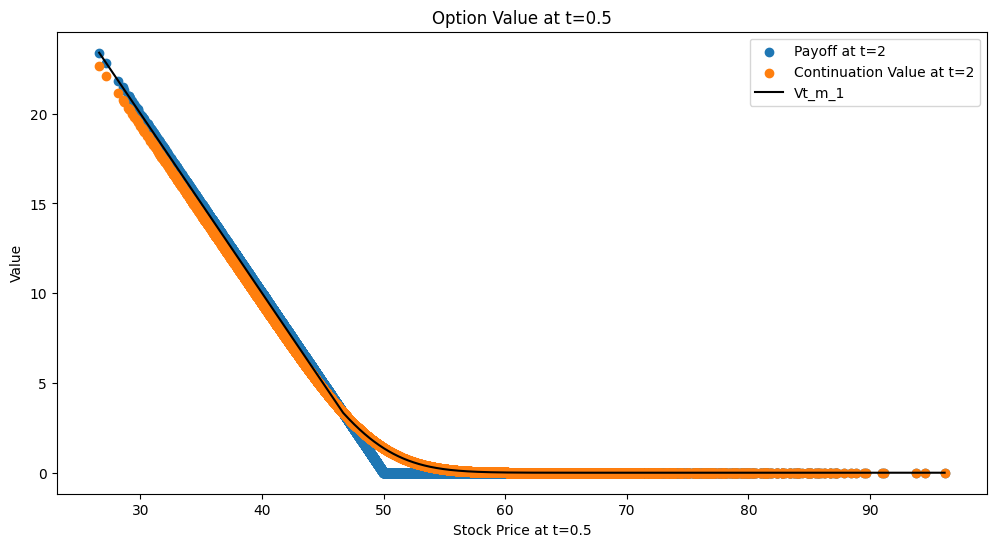

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(stock_paths[:, -2], payoff_at2, label='Payoff at t=2')
plt.scatter(stock_paths[:, -2], continuation_val, label='Continuation Value at t=2')
sorted_indices = np.argsort(stock_paths[:, -2])
plt.plot(stock_paths[:, -2][sorted_indices], Vt_m_1[sorted_indices], color='k', label='Vt_m_1')
plt.xlabel('Stock Price at t=0.5')
plt.ylabel('Value')
plt.title('Option Value at t=0.5')
plt.legend()
plt.savefig('Payoff_function_at_t=0.5.png')
plt.show()

In [17]:
normlizer = np.mean(stock_paths[:, -2])
X_tm1 = (stock_paths[:, -2]/normalizer).reshape(-1, 1)
y_tm1 = Vt_m_1.reshape(-1, 1)
X_tm1_train, X_tm1_val, y_tm1_train, y_tm1_val = train_test_split(X_tm1, y_tm1, test_size=0.2, random_state=42)
model.fit(X_tm1_train, y_tm1_train, validation_data= (X_tm1_val, y_tm1_val), 
              epochs=3000, 
              batch_size=int(0.1 * X_tm1_train.shape[0]),
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1809 - val_loss: 0.1422
Epoch 2/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1535 - val_loss: 0.1301
Epoch 3/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1375 - val_loss: 0.1180
Epoch 4/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1284 - val_loss: 0.1114
Epoch 5/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1169 - val_loss: 0.1069
Epoch 6/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1132 - val_loss: 0.1033
Epoch 7/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1109 - val_loss: 0.0963
Epoch 8/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0989 - val_loss: 0.0784
Epoch 9/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0755 - val_loss: 0.0477
Epoch 10/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0412 - val_loss: 0.0274
Epoch 11/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0258 - val_loss: 0.0233
Epoch 12/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [18]:
y_tm1_hat = model.predict(X_tm1_train)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step


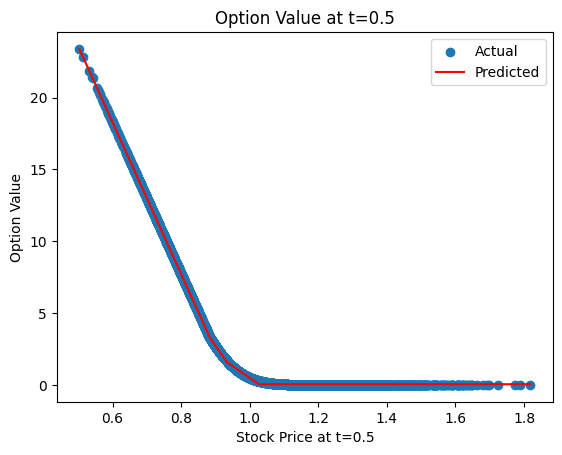

In [19]:
plt.scatter(X_tm1_train, y_tm1_train, label='Actual')
# Sort X_train and y_hat for a smoother line plot
sorted_indices = np.argsort(X_tm1_train[:, 0])  # Sort based on the first (and only) feature
X_tm1_train_sorted = X_tm1_train[sorted_indices]
y_tm1_hat_sorted = y_tm1_hat[sorted_indices]
plt.plot(X_tm1_train_sorted, y_tm1_hat_sorted, label='Predicted', color='r')
plt.xlabel('Stock Price at t=0.5')
plt.ylabel('Option Value')
plt.title('Option Value at t=0.5')
plt.legend()

In [20]:
w1 = model.layers[0].get_weights()[0].reshape(-1)
b1 = model.layers[0].get_weights()[1].reshape(-1)
w2 = model.layers[1].get_weights()[0].reshape(-1)
b2 = model.layers[1].get_weights()[1].reshape(-1)
continuation_val = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, -3], r , sigma, dt, M, normalizer)
payoff_at3 = payoff_fun(stock_paths[:, -3], K)
Vt_m_2 = np.maximum(payoff_at3, continuation_val)

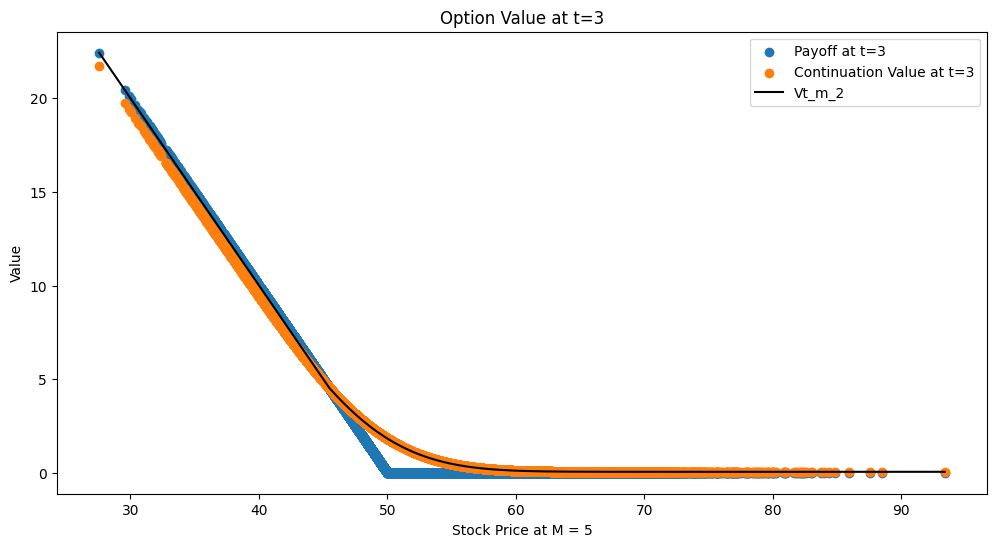

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(stock_paths[:, -3], payoff_at3, label='Payoff at t=3')
plt.scatter(stock_paths[:, -3], continuation_val, label='Continuation Value at t=3')
sorted_indices = np.argsort(stock_paths[:, -3])
plt.plot(stock_paths[:, -3][sorted_indices], Vt_m_2[sorted_indices], color='k', label='Vt_m_2')
plt.xlabel('Stock Price at M = 5')
plt.ylabel('Value')
plt.title('Option Value at t=3')
plt.legend()

In [22]:
stock_paths[0][-3], stock_paths[0]

(51.88697951512866,
 array([50.        , 51.8398659 , 43.4957171 , 44.38899885, 51.88697952,
        52.8661137 , 52.88470234]))

In [23]:
normalizer = np.mean(stock_paths[:, -3])
X_tm1 = (stock_paths[:, -3]/normalizer).reshape(-1, 1)
y_tm1 = Vt_m_2.reshape(-1, 1)
X_tm1_train, X_tm1_val, y_tm1_train, y_tm1_val = train_test_split(X_tm1, y_tm1, test_size=0.2, random_state=42)
model.fit(X_tm1_train, y_tm1_train, validation_data= (X_tm1_val, y_tm1_val), 
              epochs=3000, 
              batch_size=int(0.1 * X_tm1_train.shape[0]),
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3176 - val_loss: 0.0640
Epoch 2/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0813 - val_loss: 0.0381
Epoch 3/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0269 - val_loss: 0.0179
Epoch 4/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0071
Epoch 5/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 6/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 7/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 8/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 9/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074 - val_loss: 0.0068
Epoch 10/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 11/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 12/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [24]:
y_tm2_hat = model.predict(X_tm1_train)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step


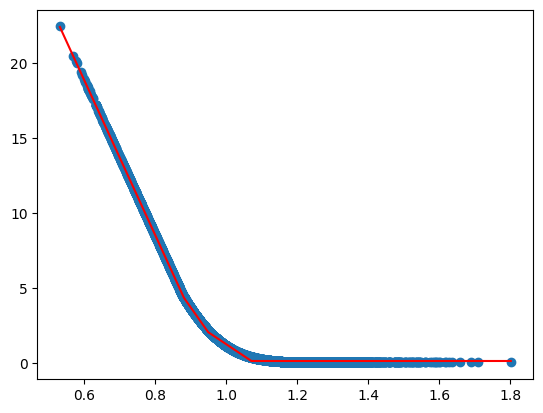

In [25]:
plt.scatter(X_tm1_train, y_tm1_train, label='Actual')
sorted_indices = np.argsort(X_tm1_train[:, 0])  # Sort based on the first (and only) feature
X_tm1_train_sorted = X_tm1_train[sorted_indices]
y_tm2_hat_sorted = y_tm2_hat[sorted_indices]
plt.plot(X_tm1_train_sorted, y_tm2_hat_sorted, label='Predicted', color='r')

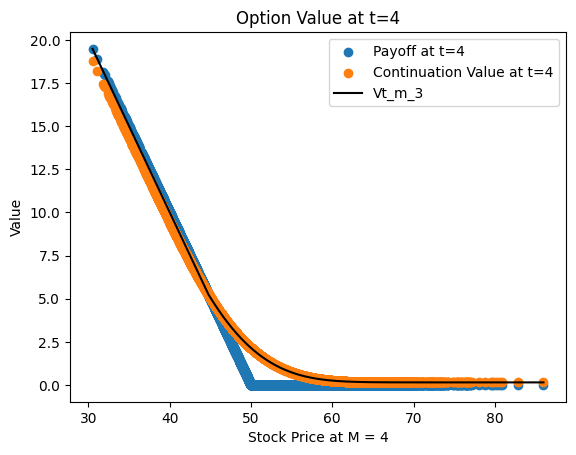

In [26]:
w1 = model.layers[0].get_weights()[0].reshape(-1)
b1 = model.layers[0].get_weights()[1].reshape(-1)
w2 = model.layers[1].get_weights()[0].reshape(-1)
b2 = model.layers[1].get_weights()[1].reshape(-1)
continuation_val = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, -4], r , sigma, dt, M, normalizer)
payoff_at4 = payoff_fun(stock_paths[:, -4], K)
Vt_m_3 = np.maximum(payoff_at4, continuation_val)
plt.scatter(stock_paths[:, -4], payoff_at4, label='Payoff at t=4')
plt.scatter(stock_paths[:, -4], continuation_val, label='Continuation Value at t=4')
sorted_indices = np.argsort(stock_paths[:, -4])
plt.plot(stock_paths[:, -4][sorted_indices], Vt_m_3[sorted_indices], color='k', label='Vt_m_3')
plt.xlabel('Stock Price at M = 4')
plt.ylabel('Value')
plt.title('Option Value at t=4')
plt.legend()

In [27]:
normalizer = np.mean(stock_paths[:, -4])
X_tm4 = (stock_paths[:, -4]/normalizer).reshape(-1, 1)
y_tm4 = Vt_m_3.reshape(-1, 1)
X_tm4_train, X_tm4_val, y_tm4_train, y_tm4_val = train_test_split(X_tm4, y_tm4, test_size=0.2, random_state=42)
model.fit(X_tm4_train, y_tm4_train, validation_data= (X_tm4_val, y_tm4_val), 
              epochs=3000, 
              batch_size=int(0.1 * X_tm4_train.shape[0]),
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1442 - val_loss: 0.0306
Epoch 2/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0380 - val_loss: 0.0202
Epoch 3/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0149
Epoch 4/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0100
Epoch 5/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 6/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 7/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 8/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 9/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - val_loss: 0.0090
Epoch 10/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 11/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 12/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step


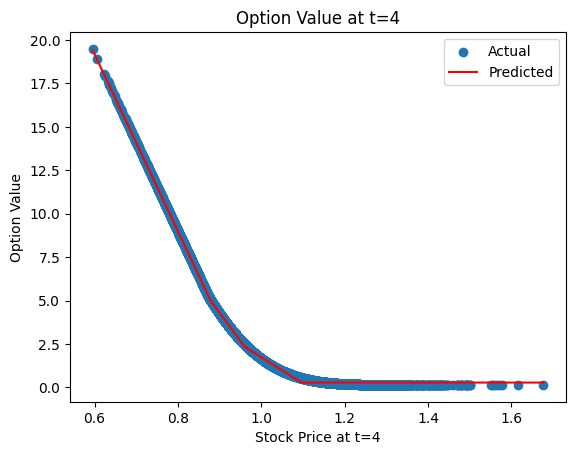

In [28]:
y_tm4_hat = model.predict(X_tm4_train)
plt.scatter(X_tm4_train, y_tm4_train, label='Actual')
sorted_indices = np.argsort(X_tm4_train[:, 0])  # Sort based on the first (and only) feature
X_tm4_train_sorted = X_tm4_train[sorted_indices]
y_tm4_hat_sorted = y_tm4_hat[sorted_indices]
plt.plot(X_tm4_train_sorted, y_tm4_hat_sorted, label='Predicted', color='r')
plt.xlabel('Stock Price at t=4')
plt.ylabel('Option Value')
plt.title('Option Value at t=4')
plt.legend()

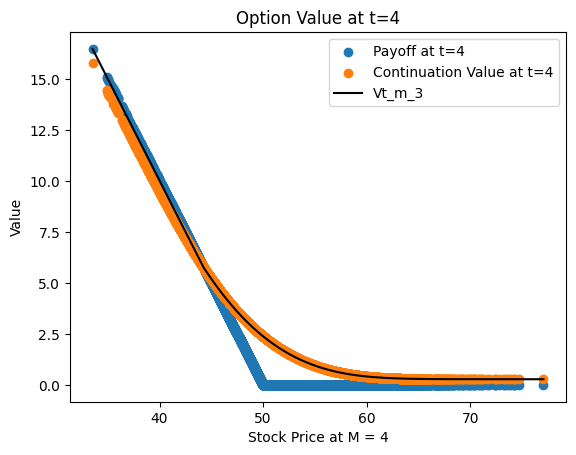

In [29]:
w1 = model.layers[0].get_weights()[0].reshape(-1)
b1 = model.layers[0].get_weights()[1].reshape(-1)
w2 = model.layers[1].get_weights()[0].reshape(-1)
b2 = model.layers[1].get_weights()[1].reshape(-1)
continuation_val = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, -5], r , sigma, dt, M, normalizer)
payoff_at4 = payoff_fun(stock_paths[:, -5], K)
Vt_m_3 = np.maximum(payoff_at4, continuation_val)
plt.scatter(stock_paths[:, -5], payoff_at4, label='Payoff at t=4')
plt.scatter(stock_paths[:, -5], continuation_val, label='Continuation Value at t=4')
sorted_indices = np.argsort(stock_paths[:, -5])
plt.plot(stock_paths[:, -5][sorted_indices], Vt_m_3[sorted_indices], color='k', label='Vt_m_3')
plt.xlabel('Stock Price at M = 4')
plt.ylabel('Value')
plt.title('Option Value at t=4')
plt.legend()

In [30]:
Vt_m_3

array([6.5042829 , 1.58981391, 5.8517709 , ..., 4.77932995, 0.54263268,
       2.8025033 ])

In [31]:
normalizer = np.mean(stock_paths[:, -5])
X_tm4 = (stock_paths[:, -5]/normalizer).reshape(-1, 1)
y_tm4 = Vt_m_3.reshape(-1, 1)
X_tm4_train, X_tm4_val, y_tm4_train, y_tm4_val = train_test_split(X_tm4, y_tm4, test_size=0.2, random_state=42)
model.fit(X_tm4_train, y_tm4_train, validation_data= (X_tm4_val, y_tm4_val), 
              epochs=3000, 
              batch_size=int(0.1 * X_tm4_train.shape[0]),
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0982 - val_loss: 0.0271
Epoch 2/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0312 - val_loss: 0.0147
Epoch 3/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0158
Epoch 4/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0119
Epoch 5/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 6/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 7/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 8/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 - val_loss: 0.0105
Epoch 9/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0098 - val_loss: 0.0104
Epoch 10/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 11/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 12/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step


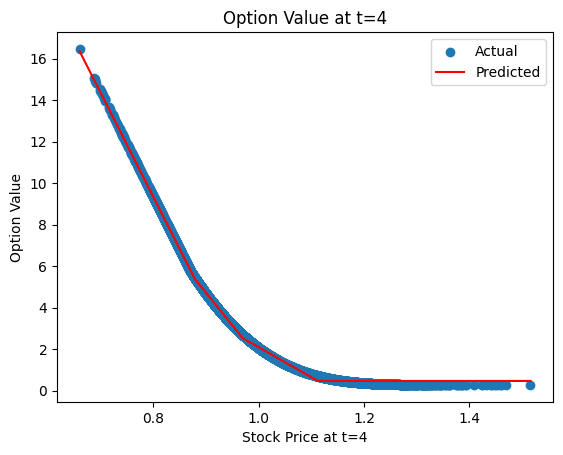

In [32]:
y_tm4_hat = model.predict(X_tm4_train)
plt.scatter(X_tm4_train, y_tm4_train, label='Actual')
sorted_indices = np.argsort(X_tm4_train[:, 0])  # Sort based on the first (and only) feature
X_tm4_train_sorted = X_tm4_train[sorted_indices]
y_tm4_hat_sorted = y_tm4_hat[sorted_indices]
plt.plot(X_tm4_train_sorted, y_tm4_hat_sorted, label='Predicted', color='r')
plt.xlabel('Stock Price at t=4')
plt.ylabel('Option Value')
plt.title('Option Value at t=4')
plt.legend()

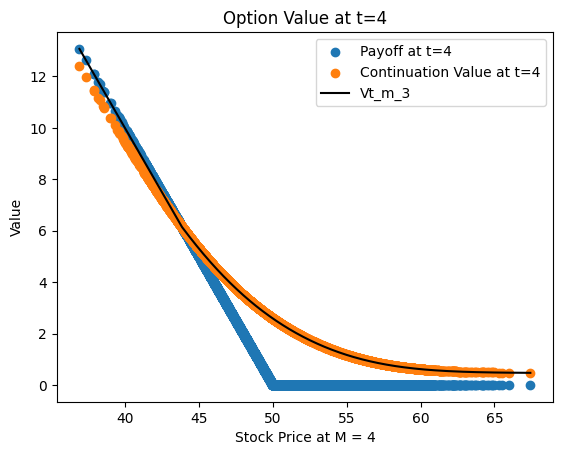

In [33]:
w1 = model.layers[0].get_weights()[0].reshape(-1)
b1 = model.layers[0].get_weights()[1].reshape(-1)
w2 = model.layers[1].get_weights()[0].reshape(-1)
b2 = model.layers[1].get_weights()[1].reshape(-1)
continuation_val = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, -6], r , sigma, dt, M, normalizer)
payoff_at4 = payoff_fun(stock_paths[:, -6], K)
Vt_m_3 = np.maximum(payoff_at4, continuation_val)
plt.scatter(stock_paths[:, -6], payoff_at4, label='Payoff at t=4')
plt.scatter(stock_paths[:, -6], continuation_val, label='Continuation Value at t=4')
sorted_indices = np.argsort(stock_paths[:, -6])
plt.plot(stock_paths[:, -6][sorted_indices], Vt_m_3[sorted_indices], color='k', label='Vt_m_3')
plt.xlabel('Stock Price at M = 4')
plt.ylabel('Value')
plt.title('Option Value at t=4')
plt.legend()

In [34]:
normalizer = np.mean(stock_paths[:, -6])
X_tm4 = (stock_paths[:, -6]/normalizer).reshape(-1, 1)
y_tm4 = Vt_m_3.reshape(-1, 1)
X_tm4_train, X_tm4_val, y_tm4_train, y_tm4_val = train_test_split(X_tm4, y_tm4, test_size=0.2, random_state=42)
model.fit(X_tm4_train, y_tm4_train, validation_data= (X_tm4_val, y_tm4_val), 
              epochs=3000, 
              batch_size=int(0.1 * X_tm4_train.shape[0]),
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0967 - val_loss: 0.0218
Epoch 2/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 - val_loss: 0.0130
Epoch 3/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - val_loss: 0.0135
Epoch 4/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - val_loss: 0.0096
Epoch 5/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 6/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 7/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 8/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 9/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 10/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 11/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 12/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step


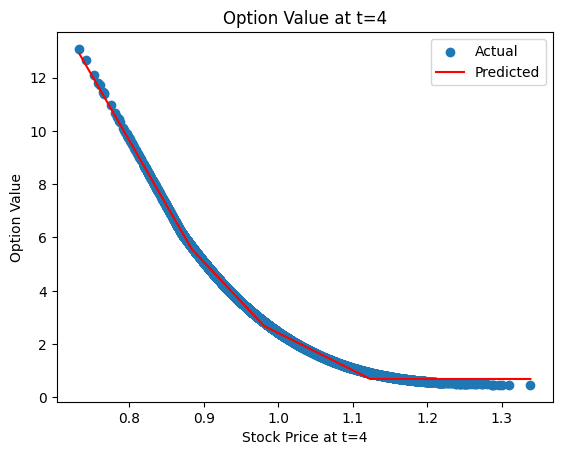

In [35]:
y_tm4_hat = model.predict(X_tm4_train)
plt.scatter(X_tm4_train, y_tm4_train, label='Actual')
sorted_indices = np.argsort(X_tm4_train[:, 0])  # Sort based on the first (and only) feature
X_tm4_train_sorted = X_tm4_train[sorted_indices]
y_tm4_hat_sorted = y_tm4_hat[sorted_indices]
plt.plot(X_tm4_train_sorted, y_tm4_hat_sorted, label='Predicted', color='r')
plt.xlabel('Stock Price at t=4')
plt.ylabel('Option Value')
plt.title('Option Value at t=4')
plt.legend()


In [36]:
w1 = model.layers[0].get_weights()[0].reshape(-1)
b1 = model.layers[0].get_weights()[1].reshape(-1)
w2 = model.layers[1].get_weights()[0].reshape(-1)
b2 = model.layers[1].get_weights()[1].reshape(-1)
continuation_val = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, -7], r , sigma, dt, M, normalizer)
payoff_at4 = payoff_fun(stock_paths[:, -7], K)
Vt_m_3 = np.maximum(payoff_at4, continuation_val)

In [37]:
Vt_m_3[0]

2.7691742739868626